In [1]:
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import numpy as np
import math

from ordered_set import OrderedSet
from collections import Counter

In [2]:
def make_barplot(x_height_pair, title):
    fig, ax = plt.subplots()
    # remove frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # remove ticks
    plt.tick_params(
        axis="both",          
        which='both',      
        bottom=False,      
        top=False,   
        left=False,    
        labelbottom=True) 
    # plot values
    for x, height in x_height_pair:
        ax.bar(x, height, alpha=0.4)
    # add white horizontal line
    yticks = ax.get_yticks()[:-1]
    for tick in yticks:
        ax.axhline(tick, c="white")
    # rotate x labels
    plt.xticks(rotation='vertical')
    # add title
    plt.title(title)
    return ax

# Overview Structure and Conditions

In [6]:
struc_and_cond = pd.read_pickle("struc-and-cond.pkl.gz", compression="gzip")

In [7]:
display(struc_and_cond)

,Entry_ID,H,B,E,G,I,T,S,Temp,PH,Ionic_strength,Pressure,Seq_length
0,5y22,10,0,0,0,0,2,3.0,298,6.7,0,1 ATM,22.0
1,6v6t,0,0,0,3,0,7,7.0,298,6,20,1 ATM,35.0
2,2v6z,47,0,4,0,0,10,5.0,298.0,6.62,NULL,1.0 ATM,75.0
3,7vzm,53,2,10,0,0,4,10.0,298,7,100,1 ATM,119.0
4,5vzm,42,2,24,13,0,24,26.0,303; 303,7.0; 6.8,20 MM SODIUM PHOSPHATE; 50 MMSODIUM PHOSPHATE,1 ATM; 1 ATM,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,5tgw,95,0,0,0,0,4,1.0,298,7.5,"100 MM NAPI, 50 MM NACL",1 ATM,109.0
5082,6tg5,63,2,0,3,0,9,6.0,293,6.7,50,1 ATM,111.0
5083,5tgy,91,0,0,0,0,5,3.0,298,7.5,"100 MM NACL, 50 MM NAPI",1 ATM,109.0
5084,2wh9,0,2,7,0,0,2,10.0,300.0,3.5,NULL,NULL,36.0


In [33]:
struc_and_cond.loc[struc_and_cond.Entry_ID == "5tgw"]

,Entry_ID,H,B,E,G,I,T,S,Temp,PH,Ionic_strength,Pressure,Seq_length
5081,5tgw,95,0,0,0,0,4,1.0,298,7.5,"100 MM NAPI, 50 MM NACL",1 ATM,109.0


Many Shift: Ich habe mir ein paar Stichproben angesehen. Folgende Fälle:
Es handelt sich um RNA (6va1,6va4,6va2,6va3, 5vh7, 5vh8, 2ldt, 5oe1) oder DNA (2mcj), die ja eigentlich gar nicht auftauchen sollte. Lösung: Rausfilter-algorithmus überprüfen bitte!
Es handelt sich um Protein/RNA-Komplexe (2n3o): Hier ist der erste der Proteinshift, der zweite der RNA-Shift.
Es handelt sich um verschiedene Messbedingungen: 2n95. Eins bei 297, eins bei 313 K (abgeleitet aus _Assigned_chem_shift_list.Data_file_name). Müsste man manuell durchgehen.
Es handelt sich um verschiedene Versionen. zB bei 6f3k. Zum Teil steht im Audit Bereich etwas von Preliminary Version und dann 1 Jah später Initial Release. Was jetzt der aktuellere Eintrag/die aktuelle Version ist ist allerdings nicht konsistent – manchmal sieht man es an den _Assigned_chem_shift_list.Data_file_name . Bei 7cnf ist bei einem …V1 und beim anderen V2 . Hier wäre also V2 die aktuellere Version. Bei anderen Einträgen ist es aber nicht so recht ersichtlich. Hier müsste man später also auch manuell durchgehen.
 
Vorschlag: DNA, RNA rausschmeißen, dann nochmal zählen lassen und Zahl für später merken. Jetzt erstmal alle Datensätze mit mehreren Shifts rauslassen.
 
Nicht AA: Anzahl an Datensätzen mit Nicht-natürlichen Aminosäuren für später notieren. Jetzt skippen.
 

In [46]:
struc_and_cond.loc[struc_and_cond.Entry_ID == "2n95"]

,Entry_ID,H,B,E,G,I,T,S,Temp,PH,Ionic_strength,Pressure,Seq_length
644,2n95,4,2,4,0,0,7,9.0,298; 313,6.4; 6.4,160; 160,AMBIENT; AMBIENT,49.0


In [47]:
struc_and_cond.loc[struc_and_cond.Entry_ID == "6f3k"]

,Entry_ID,H,B,E,G,I,T,S,Temp,PH,Ionic_strength,Pressure,Seq_length
1739,6f3k,99,12,58,3,0,34,52.0,300; 300; 328,7.5; 7.5; 8,50; 50; 50,1 ATM; 1 ATM; 1 ATM,353.0


In [48]:
struc_and_cond.loc[struc_and_cond.Entry_ID == "7cnf"]

,Entry_ID,H,B,E,G,I,T,S,Temp,PH,Ionic_strength,Pressure,Seq_length
1683,7cnf,69,0,0,0,0,4,6.0,298,6.8,175,1 PA,96.0


## Pressure

In [8]:
pressure_counts = Counter(struc_and_cond.Pressure)
pressure_counts.most_common()

[('AMBIENT', 2523),
 ('1 ATM', 1456),
 ('NULL', 146),
 ('AMBIENT ATM', 125),
 ('1 ATM; 1 ATM', 120),
 ('1.0 ATM', 97),
 ('AMBIENT; AMBIENT', 97),
 ('AMBIENT PA', 69),
 ('1 BAR', 59),
 ('1 PA', 39),
 ('760 MMHG', 22),
 ('1 ATM; 1 ATM; 1 ATM', 22),
 ('AMBIENT ATM; AMBIENT ATM', 19),
 ('AMBIENT BAR', 16),
 ('AMBIENT; AMBIENT; AMBIENT', 16),
 ('AMBIENT PA; AMBIENT PA', 11),
 ('1 BAR; 1 BAR', 11),
 ('1.0 ATM; 1.0 ATM', 11),
 ('1.000 ATM', 11),
 (None, 10),
 ('1 ATM; 1 ATM; 1 ATM; 1 ATM; 1ATM', 10),
 ('1 ATM; 1 ATM; 1 ATM; 1 ATM', 10),
 ('AMBIENT; AMBIENT; AMBIENT;AMBIENT; AMBIENT', 9),
 ('AMBIENT MBAR', 8),
 ('1.0 ATM; 1.0 ATM; 1.0 ATM', 7),
 ('AMBIENT; AMBIENT; AMBIENT;AMBIENT', 7),
 ('101325 PA', 7),
 ('NULL; NULL', 6),
 ('1 PA; 1 PA', 6),
 ('1.0 ATM; 1.0 ATM; 1.0 ATM; 1.0ATM', 5),
 ('100000 PA', 5),
 ('1.00 ATM', 5),
 ('AMBIENT ATM; AMBIENT ATM;AMBIENT ATM', 4),
 ('ARBITRARY PA', 4),
 ('AMBIENT BAR; AMBIENT BAR', 4),
 ('1013 MBAR', 3),
 ('76 MMHG', 3),
 ('1 MMHG', 3),
 ('760 TORR', 3),
 

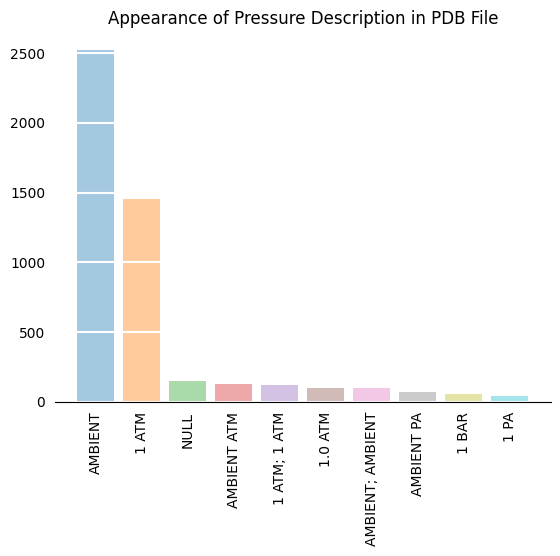

In [9]:
top_10_pressure = pressure_counts.most_common(10)
ax = make_barplot(top_10_pressure, "Appearance of Pressure Description in PDB File")

## Temperature

In [10]:
temp_counts = Counter(struc_and_cond.Temp)
temp_counts.most_common()

[('298', 2474),
 ('293', 302),
 ('303', 298),
 ('310', 162),
 ('308', 143),
 ('300', 122),
 ('298; 298', 108),
 ('313', 99),
 ('288', 89),
 ('278', 66),
 ('283', 64),
 ('298.0', 56),
 ('295', 56),
 ('285', 53),
 ('298.15', 47),
 ('305', 44),
 ('318', 37),
 ('296', 36),
 ('NULL', 29),
 ('290', 28),
 ('25', 28),
 ('280', 22),
 ('273', 22),
 ('293.15', 17),
 ('323', 16),
 ('303; 303', 15),
 ('303.15', 15),
 ('297', 15),
 ('291', 14),
 ('301', 14),
 ('277', 13),
 ('315', 13),
 ('299', 13),
 ('300; 300', 12),
 ('298; 298; 298', 11),
 ('293; 293', 11),
 ('310.15', 11),
 ('303.0', 11),
 ('293.0', 11),
 ('310; 310', 11),
 (None, 10),
 ('300.0', 10),
 ('298; 298; 298; 298', 10),
 ('298.0; 298.0', 8),
 ('298; 308', 8),
 ('275', 8),
 ('310.0', 7),
 ('20', 6),
 ('298.1', 6),
 ('308; 298', 6),
 ('298.2', 6),
 ('298; 288; 293; 303; 308', 6),
 ('278; 278', 6),
 ('288; 293; 298; 303; 308', 6),
 ('283; 298', 5),
 ('310.1', 5),
 ('328', 4),
 ('295; 285; 305; 315', 4),
 ('298.0; 298.0; 298.0', 4),
 ('303

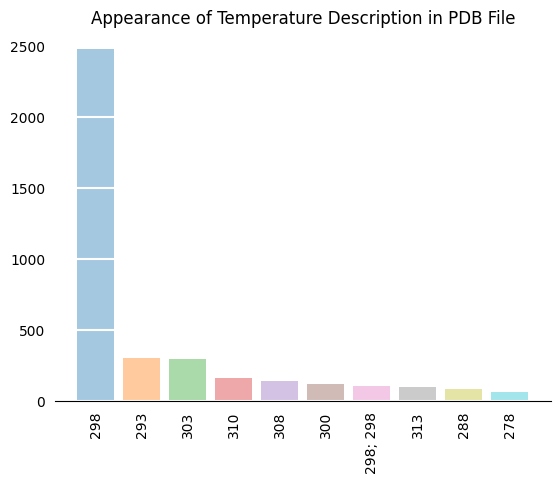

In [11]:
top_10_temp = temp_counts.most_common(10)
ax = make_barplot(top_10_temp, "Appearance of Temperature Description in PDB File")

## PH

In [12]:
PH_counts = Counter(struc_and_cond.PH)
PH_counts.most_common()

[('6.5', 831),
 ('7.0', 522),
 ('6.0', 342),
 ('7', 302),
 ('7.4', 258),
 ('6.8', 243),
 ('7.5', 181),
 ('4.5', 147),
 ('5.5', 134),
 ('6', 118),
 ('7.2', 113),
 ('5.0', 91),
 ('NULL', 91),
 ('5', 90),
 ('4', 75),
 ('6.7', 69),
 ('3.5', 69),
 ('5.8', 56),
 ('6.3', 53),
 ('4.0', 50),
 ('6.4', 50),
 ('6.9', 48),
 ('6.2', 45),
 ('6.5; 6.5', 44),
 ('6.6', 44),
 ('3.0', 31),
 ('8.0', 30),
 ('5.6', 27),
 ('6.1', 24),
 ('7.3', 24),
 ('7.4; 7.4', 23),
 ('7.0; 7.0', 20),
 ('7.1', 20),
 ('5.7', 20),
 ('8', 19),
 ('4.6', 19),
 ('7.8', 18),
 ('6.0; 6.0', 17),
 ('4.7', 16),
 ('3.7', 16),
 ('3', 15),
 ('2.5', 15),
 ('7.6', 13),
 ('4.2', 13),
 ('7; 7', 13),
 ('6.8; 6.8', 13),
 ('4.8', 12),
 ('7.5; 7.5', 11),
 ('5.4', 11),
 ('5.9', 11),
 ('7.00', 11),
 ('5.2', 11),
 ('3.8', 11),
 ('1.9', 11),
 ('4.3', 11),
 ('3.3', 10),
 (None, 10),
 ('4.5; 4.5', 10),
 ('3.5; 3.5', 9),
 ('6; 6', 9),
 ('7.7', 9),
 ('5.1', 9),
 ('5.5; 5.5', 9),
 ('4.1', 9),
 ('0.0', 8),
 ('3.5; 3.5; 3.5; 3.5; 3.5', 8),
 ('3.6', 7),
 ('8

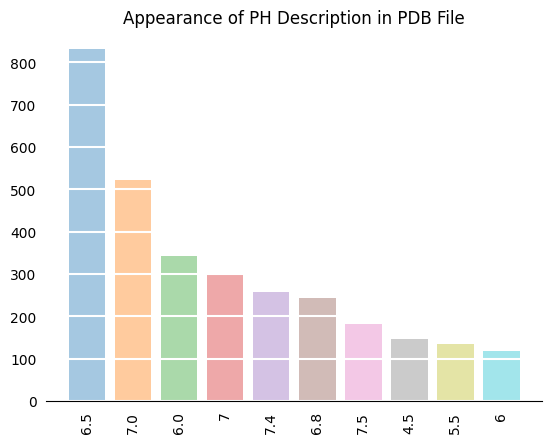

In [13]:
top_10_PH = PH_counts.most_common(10)
ax = make_barplot(top_10_PH, "Appearance of PH Description in PDB File")

## Ionic Strength

In [14]:
Ionic_strength_counts = Counter(struc_and_cond.Ionic_strength)
Ionic_strength_counts.most_common()

[('NULL', 912),
 ('0', 474),
 ('50', 305),
 ('100', 279),
 ('20', 191),
 ('150', 188),
 ('0.1', 177),
 ('0.05', 116),
 ('10', 99),
 ('0.15', 94),
 ('200', 84),
 ('0.2', 83),
 ('120', 65),
 ('300', 56),
 ('0.02', 49),
 ('70', 47),
 ('NULL; NULL', 45),
 ('0.01', 37),
 ('NA', 37),
 ('25', 35),
 ('0.12', 35),
 ('1', 34),
 ('0; 0', 31),
 ('0.3', 25),
 ('250', 25),
 ('125', 24),
 ('40', 24),
 ('30', 21),
 ('5', 21),
 ('50; 50', 21),
 ('100; 100', 20),
 ('0.025', 20),
 ('0.5', 19),
 ('0.08', 19),
 ('2', 17),
 ('0.11', 17),
 ('0.0798', 17),
 ('50 MM NACL', 15),
 ('0.07', 15),
 ('0.220', 15),
 ('80', 14),
 ('0; 0; 0; 0; 0', 14),
 ('60', 13),
 ('500', 13),
 ('170', 13),
 ('75', 13),
 ('100 MM NACL', 11),
 ('140', 11),
 ('160', 11),
 ('0.6', 11),
 ('0.06', 11),
 ('0.150', 11),
 (None, 10),
 ('0.04', 10),
 ('350', 10),
 ('20; 20', 10),
 ('450', 10),
 ('150; 150', 10),
 ('225', 9),
 ('NOT DEFINED', 9),
 ('0.35', 9),
 ('0.100', 9),
 ('0.420', 9),
 ('55', 8),
 ('0.16', 8),
 ('130', 8),
 ('0.4', 8),
 

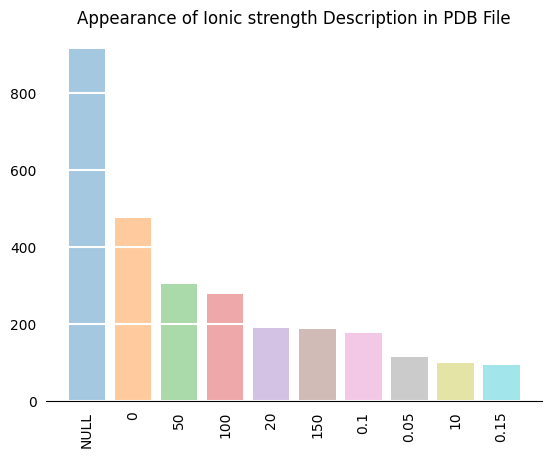

In [15]:
top_10_Ionic_strength = Ionic_strength_counts.most_common(10)
ax = make_barplot(top_10_Ionic_strength, "Appearance of Ionic strength Description in PDB File")

# Future Tasks

The barplots do not show the count of a certain value for the specific condition, but only the appearance of them in the pdb files.
- ATM and 1 ATM are not the same in the barplot
- ATM and Ambient are not the same in the barplot

To use the data in a useful manner, the data has to be converted in a way that all data are in the **same format** and have only **one value** associated per Entry_ID.

# Overview Chemical Shifts

In [16]:
chemical_shifts = pd.read_pickle("chemical-shifts.pkl.gz", compression="gzip")

In [17]:
display(chemical_shifts)

,Comp_index_ID,Comp_ID,Atom_ID,Atom_type,Val,Entry_ID
0,20,ARG,HG2,H,1.725,5Y22
1,11,TRP,HE1,H,9.767,5Y22
2,11,TRP,NE1,N,126.854,5Y22
3,4,ILE,H,H,7.484,5Y22
4,4,ILE,N,N,116.491,5Y22
...,...,...,...,...,...,...
1333,113,GLN,HB3,H,1.806,7WH3
1334,113,GLN,C,C,177.589,7WH3
1335,113,GLN,CA,C,54.441,7WH3
1336,113,GLN,CB,C,27.954,7WH3


# Comparison of Entry IDs in both dataframes

In [18]:
unique_shifts_counts = len(set(chemical_shifts.Entry_ID))
unique_struc_cond_counts = len(set(struc_and_cond.Entry_ID))
print(f"The chemical shift dataframe consist of {unique_shifts_counts} unique Entry_IDs and the condition and structure dataframe consist of {unique_struc_cond_counts} unique Entry_IDs")

The chemical shift dataframe consist of 5086 unique Entry_IDs and the condition and structure dataframe consist of 5086 unique Entry_IDs


In [19]:
# in struc_and_cond the pdb_id is lowercase and in chemical_shifts uppercase
struc_and_cond_upper = struc_and_cond.Entry_ID.apply(lambda x: x.upper())

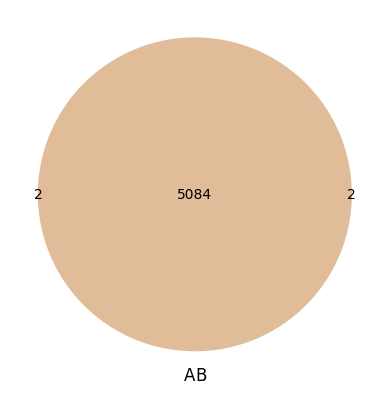

In [20]:
venn2([set(chemical_shifts.Entry_ID), set(struc_and_cond_upper)])

In [21]:
set(struc_and_cond_upper) - set(chemical_shifts.Entry_ID)

{'2M84', '5MCS'}

In [22]:
set(chemical_shifts.Entry_ID) - set(struc_and_cond_upper)

{'.', '19226'}

**'5mcs' is '.'.**
**'2M84' is '19226'.**

Checked out in the nmrstar file.

# Files not Found

In [23]:
with open("files-not-found.txt", "r") as infile:
    files_not_found = infile.readlines()

In [24]:
not_found_counts = Counter(files_not_found)
not_found_counts.most_common()

[('Protein Error\n', 619),
 ('Path Error\n', 26),
 ('Column Header Error\n', 9),
 ('Entry_ID Error\n', 3),
 ('PDB ID Error\n', 1),
 ('PDB Request Error\n', 1)]

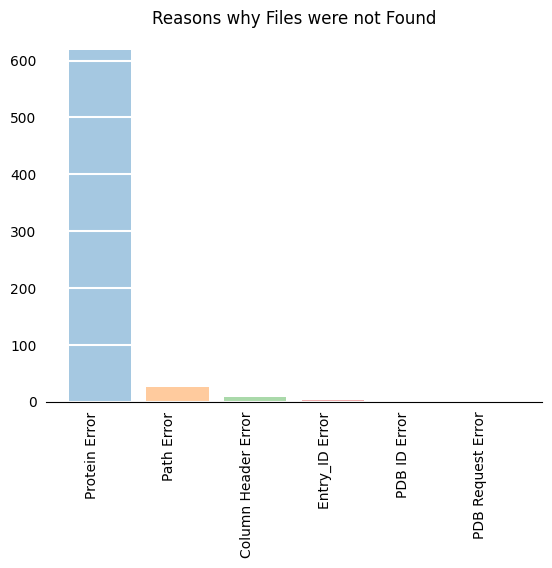

In [25]:
ax = make_barplot(not_found_counts.most_common(), "Reasons why Files were not Found")

# Additional

There were some files with amino acid comp_id mixed with other three letter code. 
One example is 7QGV with ZAE as first three letter code and there are more.
If the three letter code like in 7QGV wouldn't be in first place, the data would be inconsistent.

The problem is that DNA/RNA has also sometimes a three letter id for some sequences.
One could distinguish between protein and DNA/RNA by the average length of the Comp_ID.

In [26]:
amino_acid_code = [
            "ALA",
            "ASP",
            "CYS",
            "GLU",
            "PHE",
            "GLY",
            "HIS",
            "ILE",
            "LYS",
            "LEU",
            "MET",
            "ASN",
            "PRO",
            "GLN",
            "ARG",
            "SER",
            "THR",
            "VAL",
            "TRP",
            "TYR"
            ]

In [27]:
non_aa_comp_ids = []
IDs = chemical_shifts.Entry_ID.to_list()
for i, comp_ID in enumerate(chemical_shifts.Comp_ID):
    if comp_ID not in amino_acid_code:
        #print(IDs[i], comp_ID)
        non_aa_comp_ids.append((IDs[i], comp_ID))

In [29]:
set(non_aa_comp_ids)

{('.', 'HEC'),
 ('19226', 'AF2'),
 ('19226', 'CFL'),
 ('19226', 'CFZ'),
 ('19226', 'GF2'),
 ('19226', 'GFL'),
 ('19226', 'TAF'),
 ('1E74', 'NH2'),
 ('1E75', 'NH2'),
 ('1E76', 'NH2'),
 ('1Q80', 'SAC'),
 ('1QMW', 'NH2'),
 ('2AP8', 'DIL'),
 ('2CEF', 'SEP'),
 ('2CEZ', 'SEP'),
 ('2CFJ', 'SEP'),
 ('2JQB', 'DPN'),
 ('2JQB', 'HYP'),
 ('2JT8', 'FTR'),
 ('2JW1', 'ACE'),
 ('2JX9', 'NAG'),
 ('2K03', 'TYS'),
 ('2K05', 'TYS'),
 ('2K17', 'M3L'),
 ('2K3U', 'ACE'),
 ('2K3U', 'NH2'),
 ('2K3U', 'TYS'),
 ('2K9E', 'NH2'),
 ('2K9E', 'NLE'),
 ('2K9E', 'PFX'),
 ('2KB2', 'FMN'),
 ('2KB3', 'TPO'),
 ('2KFU', 'TPO'),
 ('2KGI', 'M3L'),
 ('2KID', 'B27'),
 ('2KMX', 'ATP'),
 ('2KO8', 'FME'),
 ('2KQQ', 'DAL'),
 ('2KSC', 'HEB'),
 ('2KSI', 'PLM'),
 ('2KUG', 'HAL'),
 ('2KVM', 'MLY'),
 ('2L0E', 'ALY'),
 ('2L12', 'M3L'),
 ('2L1B', 'M3L'),
 ('2L2S', 'F191'),
 ('2L3R', 'M3L'),
 ('2L5E', 'ALY'),
 ('2L6X', 'LYR'),
 ('2L75', 'M3L'),
 ('2L7S', 'NH2'),
 ('2L7U', 'MCL'),
 ('2L87', 'TYS'),
 ('2L8R', 'APR'),
 ('2L98', 'STL'),
 ('2L9